# RSBW and ALBW tracer seasonality
Tracers are averaged over bottom 500 m and are pre-saved (``g/data/x77/ps7863/python_scripts/AABW_variability/py-files/save_bottom_tracer.py``) 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
from cosima_cookbook import explore

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.path as mpath
from matplotlib import ticker, cm
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
import glob,os
import climtas.nci
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmcrameri


import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sys
sys.path.append("/g/data/x77/ps7863/python_scripts")
import helper_functions as helper

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
figdir = '/g/data/x77/ps7863/figures/AABW_variability/'

In [3]:
climtas.nci.GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37811/status,
Dashboard: /proxy/37811/status,Workers: 48
Total threads: 48,Total memory: 190.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44483,Workers: 48
Dashboard: /proxy/37811/status,Total threads: 48
Started: Just now,Total memory: 190.00 GiB
Comm: tcp://127.0.0.1:39665,Total threads: 1
Dashboard: /proxy/41939/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:46779,


In [4]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
expt = '01deg_jra55v140_iaf_cycle3_antarctic_tracers'

In [5]:
first_year = '1958'
last_year = '2018'
start_time=first_year+'-01-01'
end_time=last_year+'-12-31'
time_slice = slice(start_time, end_time)

lon_slice = slice(80-360, 190-360)
lat_slice = slice(-82, -55)

In [6]:
ht = cc.querying.getvar(iaf_cycle3,'ht',session, n=1) 
ht = ht.sel(yt_ocean = lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

In [7]:
shelf_mask = ht > 1000
shelf_mask = shelf_mask.astype(bool)
masked_shelf = shelf_mask.where(shelf_mask==0, np.nan)
shelf_mask = shelf_mask.where(shelf_mask==1, np.nan)

In [19]:
albw_tracer = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/ALBW_tracer_bottom_500_1958-2018.nc')
rsbw_tracer = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/RSBW_tracer_bottom_500_1958-2018.nc')

albw_tracer = albw_tracer['ALBW_tracer']
rsbw_tracer = rsbw_tracer['RSBW tracer']

In [9]:
albw_clim = albw_tracer.groupby('time.month').mean('time')
rsbw_clim = rsbw_tracer.groupby('time.month').mean('time')

In [10]:
where_nan = np.isnan(albw_clim.sel(month=1))
albw_clim = albw_clim.where(~where_nan,0)
where_nan = np.isnan(rsbw_clim.sel(month=1))
rsbw_clim = rsbw_clim.where(~where_nan,0)

In [11]:
albw_peak_month = albw_clim.argmax('month')+1
rsbw_peak_month = rsbw_clim.argmax('month')+1

In [12]:
albw_range = albw_clim.max(dim='month') - albw_clim.min(dim='month')
rsbw_range = rsbw_clim.max(dim='month') - rsbw_clim.min(dim='month')


In [16]:
albw_peak_month

<xarray.DataArray 'ALBW_tracer' (yt_ocean: 584, xt_ocean: 1100)> Size: 5MB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [2, 1, 1, ..., 6, 6, 6],
       [1, 1, 1, ..., 6, 6, 6],
       [1, 1, 1, ..., 6, 6, 6]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 9kB -279.9 -279.8 -279.7 ... -170.1 -170.0
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01

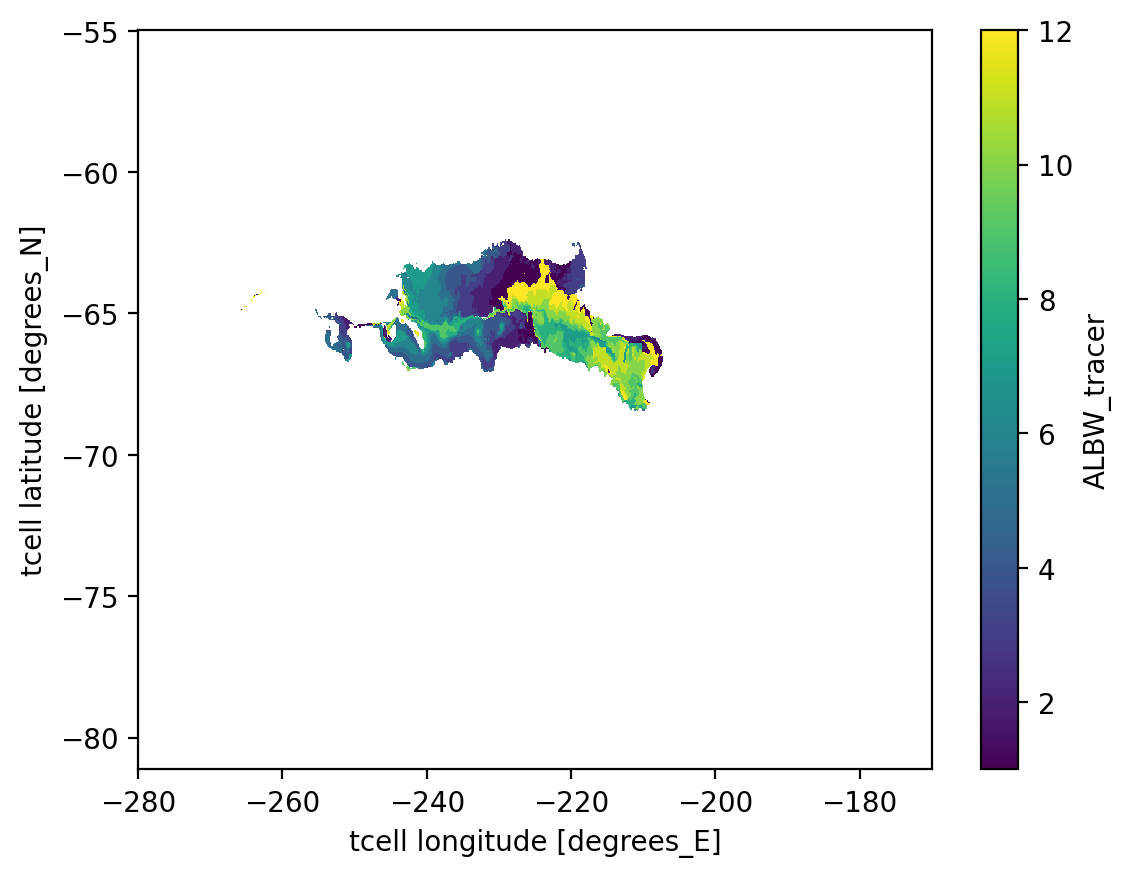

In [21]:
albw_peak_month.where(albw_range > 0.015).plot()

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [14]:
land_50m = cfeature.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="grey", linewidth=0.5
)

In [15]:
xt_ocean = ht.xt_ocean
yt_ocean = ht.yt_ocean

In [16]:
X, Y = np.meshgrid(xt_ocean, yt_ocean)
X = xr.DataArray(X, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])
Y = xr.DataArray(Y, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])

In [17]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [18]:
# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [20]:
mask_rsbw = rsbw_range >= 0.005
rsbw_peak_masked = rsbw_peak_month.where(mask_rsbw)

mask_albw = albw_range >= 0.005
albw_peak_masked = albw_peak_month.where(mask_albw)

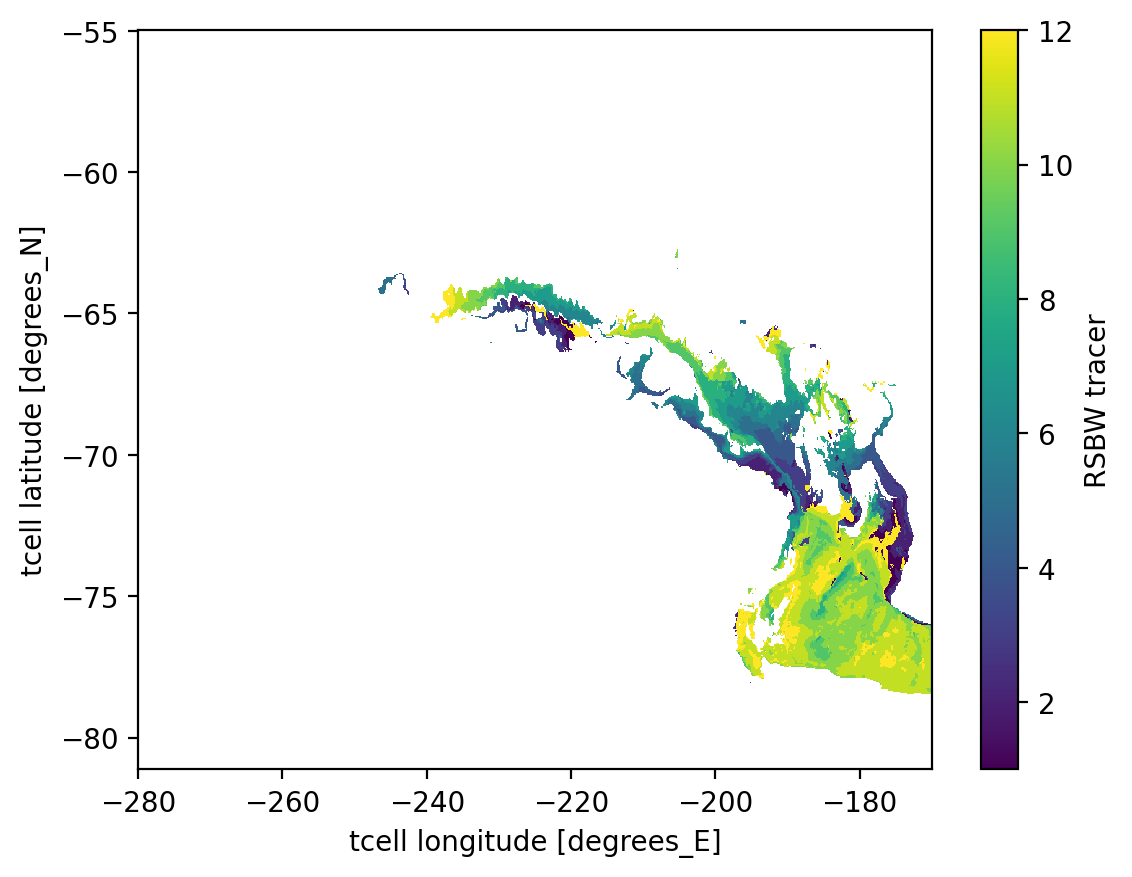

In [29]:
mask_rsbw.plot()

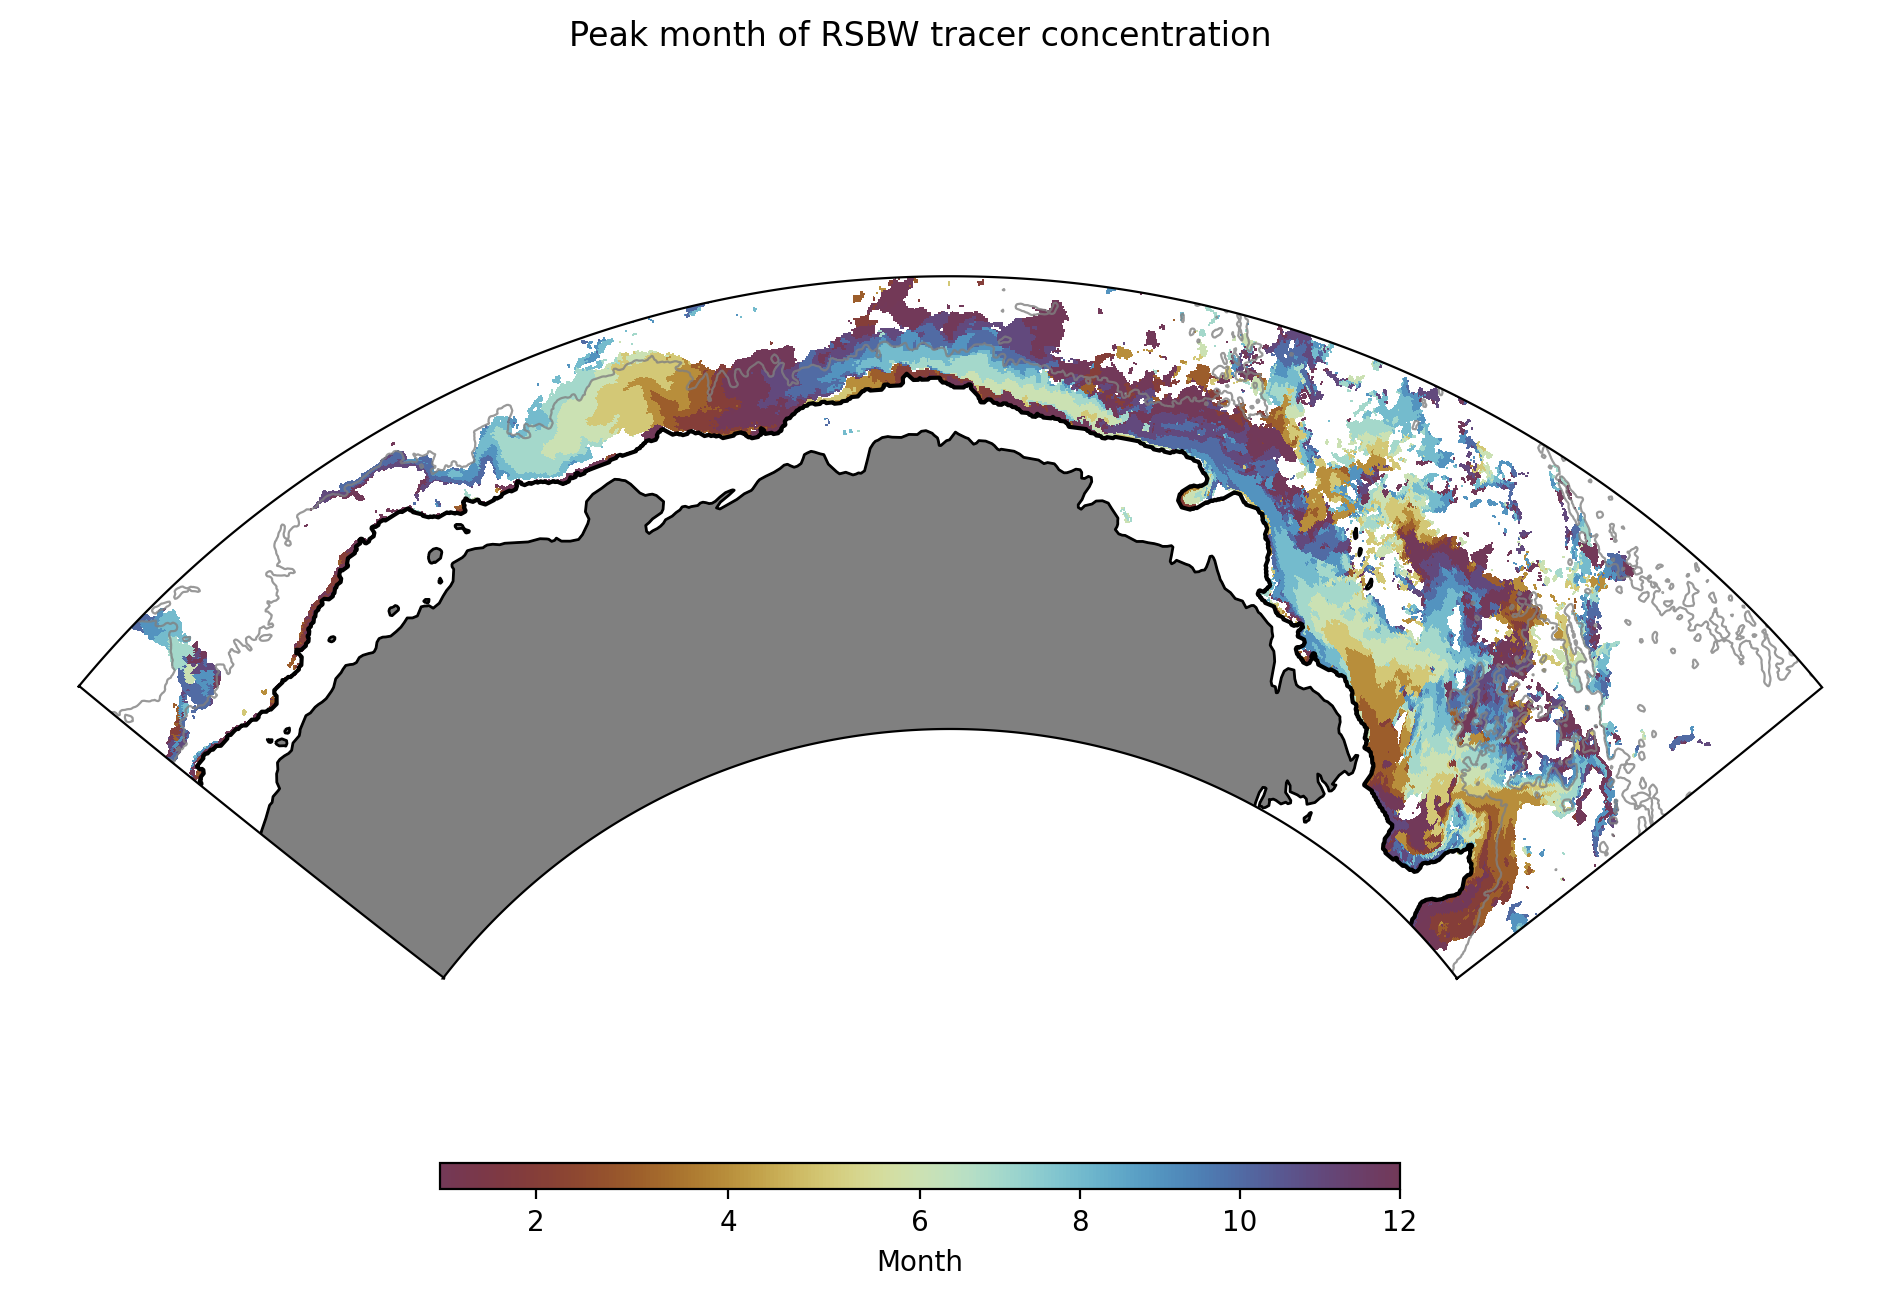

In [21]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -74
maxlat = -62
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=1, vcenter=6, vmax=12)
cmap = cmcrameri.cm.romaO
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, rsbw_peak_masked*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.set_label(f'Month')

plt.suptitle('Peak month of RSBW tracer concentration')

plt.savefig(f'{figdir}/rsbw_peak_month_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


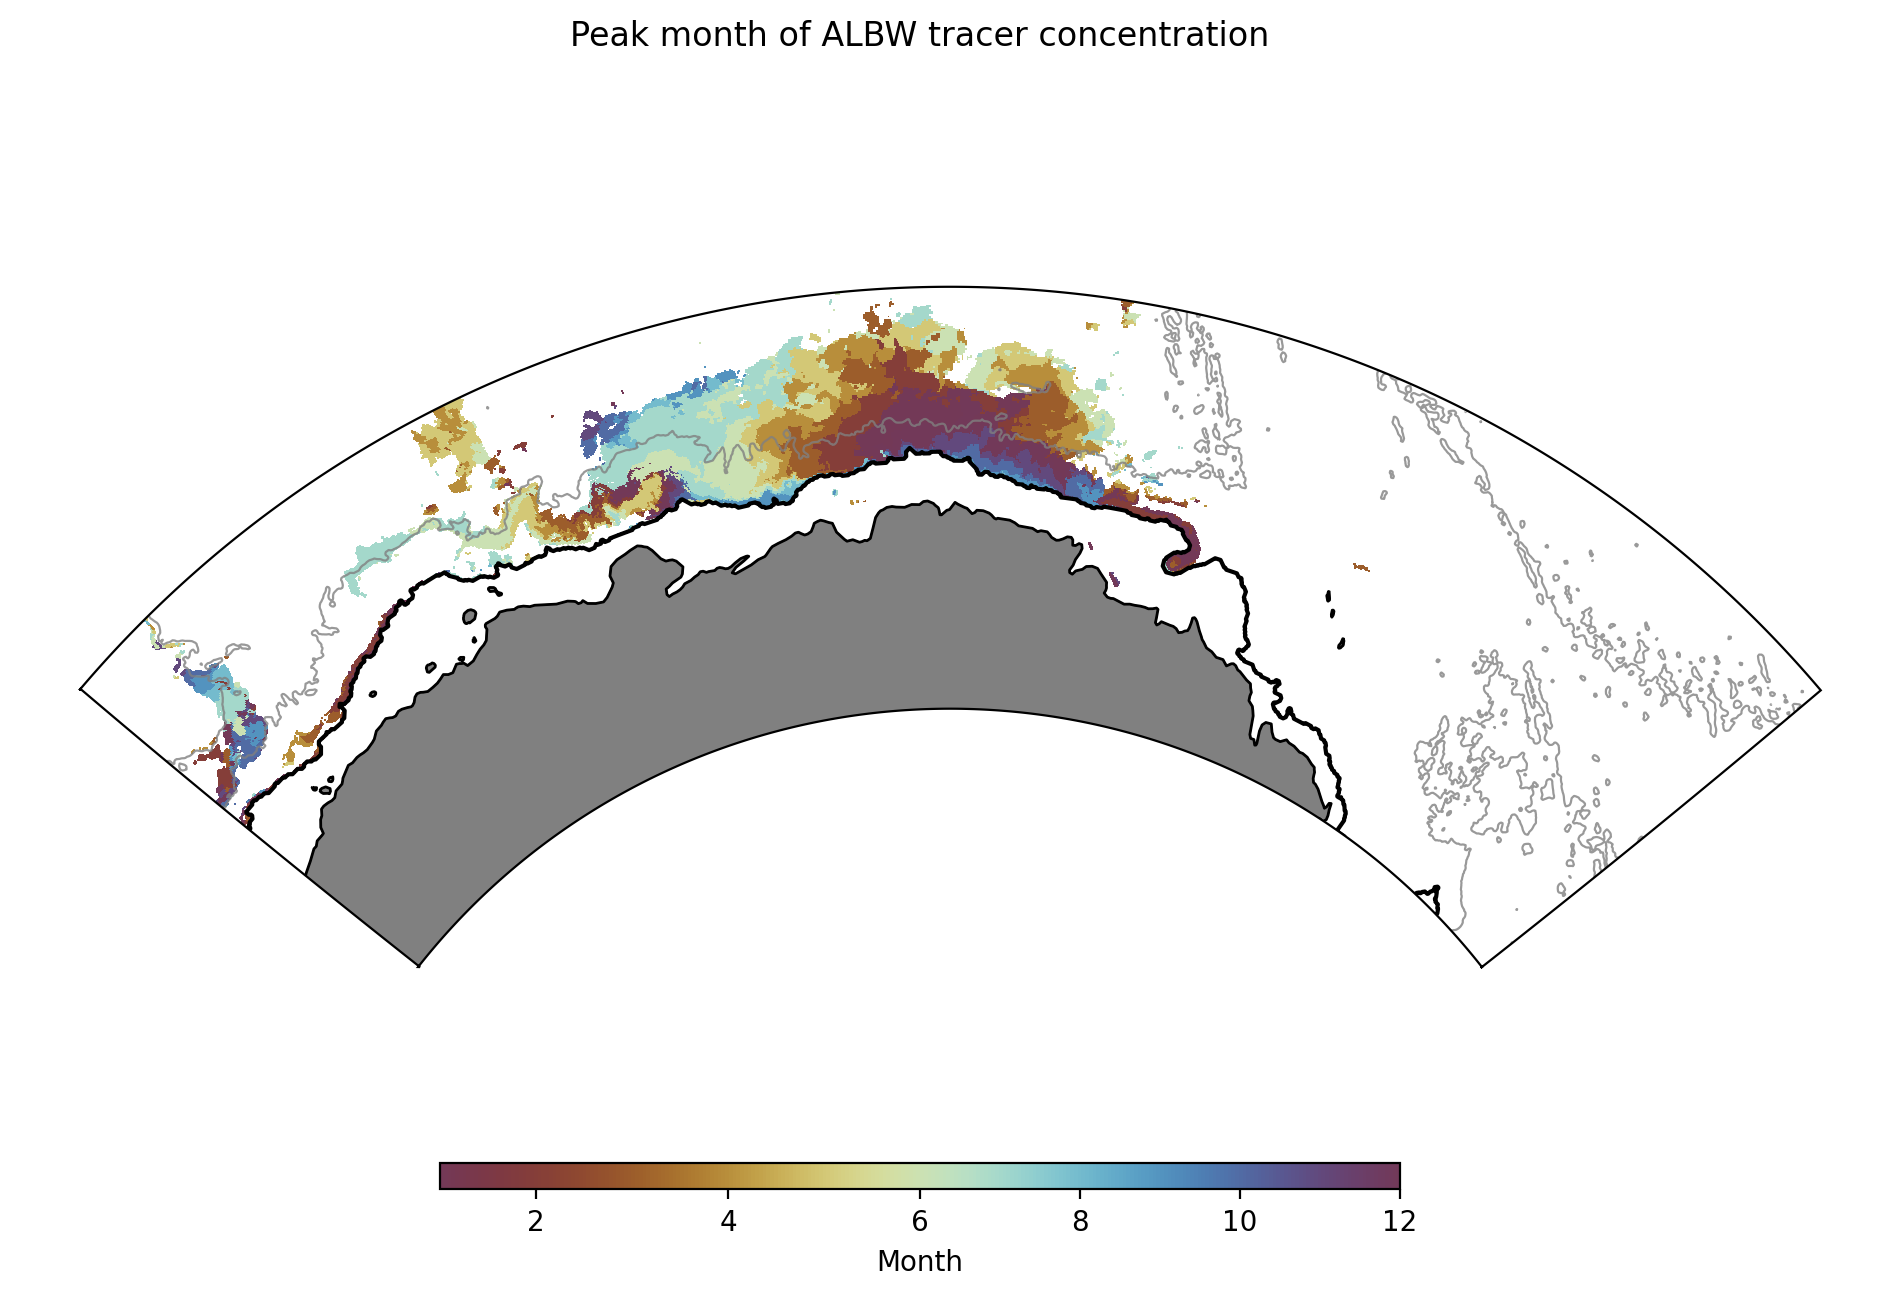

In [22]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -72
maxlat = -60
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=1, vcenter=6, vmax=12)
cmap = cmcrameri.cm.romaO
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, albw_peak_masked*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.set_label(f'Month')

plt.suptitle('Peak month of ALBW tracer concentration')

plt.savefig(f'{figdir}/albw_peak_month_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')
